In [392]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [215]:
class States:
    def __init__(self, k):
        self.states = []
        for i in range(-1,k+1):
            for j in range(-1,k+1):
                for j2 in range(-1,k+1):
                    self.states.append((i,j,j2))
    
    def getState(self, ind):
        return self.states[ind]

    def getInd(self, state):
        return self.states.index(state)
    
    def __len__(self):
        return len(self.states)

In [155]:
class Actions:
    def __init__(self):
        # 0 = adopt, 1 = wait
        self.actions = []
        for i in range(2):
            for j in range(2):
                for j2 in range(2):
                    self.actions.append((i,j,j2))
    
    def getAction(self, ind):
        return self.actions[ind]

    def getInd(self, state):
        return self.actions.index(state)
    
    def __len__(self):
        return len(self.actions)

In [397]:
class Agent:
    def __init__(self, k, lr=0.5):
        self.k = k
        self.states = States(k)
        self.actions = Actions()
        self.lr = lr
        self.qtable = np.zeros((len(self.states), len(self.actions))) + \
                      np.random.randn(len(self.states), len(self.actions)) / float(1e6)
    
    def epsilonGreedySelection(self, state, epsilon=0.1):
        # Random action w.p. epsilon
        if np.random.rand() < epsilon:
            return self.actions.actions[np.random.choice(np.arange(len(self.actions)))]
        
        # otherwise take argmax.
        ind = self.states.getInd(state)
        return self.actions.actions[np.argmax(self.qtable[ind])]
    
    def updateQTable(self, state, next_state, action, reward):
        ind = self.states.getInd(tuple(state))
        next_ind = self.states.getInd(tuple(next_state))
        self.qtable[ind, action] += self.lr * (reward + np.max(self.qtable[next_ind]) - self.qtable[ind, action])

In [398]:
class World:
    def __init__(self, k, W):
        self.agent = Agent(k)
        self.k = k
        self.W = W
    
    def runEpisode(self):
        state = [0,0,0]
        while state != [-1, -1, -1]:
            action = self.agent.epsilonGreedySelection(tuple(state))
            new_state = copy.deepcopy(state)
            
            # flipping state for adopters.
            for i, a in enumerate(action):
                if a == 0:
                    new_state[i] = -1
            
            # players who are waiting.
            players = np.where(np.array(action) != 0)[0]
            
            # block producer
            if len(players):
                block_producer = np.random.choice(players)
                new_state[block_producer] += 1
                
            reward = self.getReward(state, new_state, action)
            
            self.agent.updateQTable(state, new_state, action, reward[0])
            
            # switching order to use other reward.
            permutation1_curr = [state[1], state[0], state[2]]
            permutation1_next = [new_state[1], new_state[0], new_state[2]]
            permutation1_action = [action[1], action[0], action[2]]
            self.agent.updateQTable(permutation1_curr, permutation1_next, permutation1_action, reward[1])
            
            permutation2_curr = [state[2], state[1], state[0]]
            permutation2_next = [new_state[2], new_state[1], new_state[0]]
            permutation2_action = [action[2], action[1], action[0]]
            self.agent.updateQTable(permutation2_curr, permutation2_next, permutation2_action, reward[2])
            
            # check for winner.
            if len(players) == 1:
                break
            
           
        
    def getReward(self, old_state, new_state, action):
        reward = [0, 0, 0]
        for i in range(len(old_state)):
            # Try to wait after adopting. Make this outcome bad.
            if (old_state[i] == -1) and (action[i] == 1):
                reward[i] = -1000
            
            # Adopting in non adopted state.
            if (old_state[i] != -1) and (action[i] == 0):
                reward[i] = -old_state[i]
                
        # Winner.
        players = np.where(np.array(action) != 0)[0]
        if len(players) == 1:
            reward[players[0]] += self.W
        
        return reward

    def qLearn(self, iterations):
        for _ in tqdm(range(iterations)):
            self.runEpisode()

In [410]:
world = World(k=3, W=2)
world.qLearn(iterations=10000)

100%|██████████| 10000/10000 [00:01<00:00, 6091.40it/s]


In [411]:
table = world.agent.qtable

In [412]:
table.shape

(125, 8)

([<matplotlib.lines.Line2D at 0x11a3f6a30>], 31)

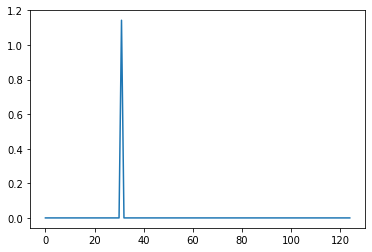

In [422]:
plt.plot(table[:,0]), np.argmax(table[:,0])

In [424]:
world.agent.states.getState(31)

(0, 0, 0)